In [ ]:
import openai
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

OPEN_AI_KEY='OPEN_AI_KEY'
client = openai.OpenAI(api_key=OPEN_AI_KEY)


In [ ]:
!pip install requests beautifulsoup4

# Step 1: Extract article links from write of passage posts

In [ ]:
import requests
import json
import time
import re

def find_href_values(obj, search_key):
    href_values = []
    if isinstance(obj, dict):
        for key, value in obj.items():
            if key == search_key:
                href_values.append(value)
            else:
                href_values.extend(find_href_values(value, search_key))
    elif isinstance(obj, list):
        for item in obj:
            href_values.extend(find_href_values(item, search_key))
    return href_values

def fetch_published_list(page_index, max_per_page, headers):
    published_lists_endpoint = "https://home.writeofpassage.school/internal_api/spaces/1303617/posts?page=" + str(page_index) + "&include_top_pinned_post=false&used_on=list&per_page=" + str(max_per_page)
    response = requests.get(published_lists_endpoint, headers=headers)
    print("got resopnse", response.status_code, "for page", page_index)
    res = json.loads(response.text)
    return res

def get_all_urls():
  max_per_page = 30
  page_index = 1
  headers = {
      "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
      "Cookie": 'INSERT_COOKIE'}
  has_next_page = True
  substack_links = set()
  while(has_next_page and page_index < 5):
    res = fetch_published_list(page_index, max_per_page, headers)

    links = find_href_values(res, "href")
    substack_links.update(links)

    page_index += 1
    if res["has_next_page"] == "false":
      has_next_page = False
    time.sleep(3)
    print("Waited for 3 seconds!")
  return substack_links

In [ ]:
result = get_all_urls()

got resopnse 200 for page 1
Waited for 3 seconds!
got resopnse 200 for page 2
Waited for 3 seconds!
got resopnse 200 for page 3
Waited for 3 seconds!
got resopnse 200 for page 4
Waited for 3 seconds!


{'/u/ebdaa5ed',
 'https://94040.substack.com/p/bamboo-learnings',
 'https://aashisha.substack.com/p/the-mind-bin',
 'https://acaiberry.substack.com/p/analog-oasis',
 'https://adia.substack.com/p/the-language-of-limitation',
 'https://amberthe.substack.com/p/love-needs-more-nothing',
 'https://amitwrites.substack.com/p/survival-of-the-kindest',
 'https://anthonymarigold.substack.com/p/guerrilla-writers-and-the-literary',
 'https://axiacore.com/blog/what-can-we-learn-from-a-race-car-driver-about-business-949/',
 'https://beckyisj.substack.com/p/on-being-the-responsive-kid',
 'https://blog.amitbhatnagar.com/p/when-a-million-dreams-were-not-enough',
 'https://changealchemist.substack.com/p/a-sharp-knife-is-all-i-need?r=4qrg7',
 'https://changesurfer.substack.com/p/how-to-walk-to-a-mens-group',
 'https://chengweihu.substack.com/p/emotional-freedom',
 'https://clairebutler.substack.com/p/looking-my-fertility-cliff-in-the',
 'https://coco.substack.com/p/slow-spaces-for-conversation',
 'https:

# Step 2: Cleanup Urls

In [ ]:
def filter_urls(links):
    # Combined pattern to match URLs starting with https and not containing 'google' or 'twitter'
    pattern = r"^https://(?!.*(google|twitter))[^?\s]*"

    # Filter and clean up URLs in one step
    cleaned_urls = [
        re.match(pattern, url).group(0)
        for url in links
        if re.match(pattern, url)
    ]

    return cleaned_urls

In [ ]:
published_articles = filter_urls(result)
len(published_articles)

99

# Step 3: Scrape articles and save to CSV

In [ ]:
import requests
from bs4 import BeautifulSoup
import csv
import time

def scrape_article(url):
    try:
        # Fetch the webpage
        response = requests.get(url)
        response.raise_for_status()  # Check if the request was successful

        # Parse the HTML content
        soup = BeautifulSoup(response.text, 'html.parser')

        # Extract the main article content
        article_contents = soup.find_all('p')

        text = ""
        if len(article_contents) > 0:
          for article_content in article_contents:
              # Remove all HTML tags and get the text
              text += article_content.get_text(separator='\n').replace("\n", "").strip()
          print("length of article", len(text))
          return text
        else:
            print("Could not find the article content on the page.")
            return None

    except requests.exceptions.RequestException as e:
        print(f"An error occurred while fetching the URL: {e}")
        return None

def save_articles_to_csv(urls, output_file, mode):
    # Open the CSV file in write mode
    with open(output_file, mode, newline='', encoding='utf-8') as csv_file:
        writer = csv.writer(csv_file)

        # Write the header
        writer.writerow(['URL', 'Article'])

        # Scrape each URL and write the data to the CSV
        for url in urls:
            print(f"Scraping URL: {url}")
            article_text = scrape_article(url)
            time.sleep(1)

            if article_text:
                # Write the URL and article content to the CSV file
                writer.writerow([url, article_text])
                print(f"Article saved for URL: {url}")
            else:
                print(f"Failed to retrieve content for URL: {url}")



In [ ]:
save_articles_to_csv(substack_articles[:50], "articles", "w")

In [ ]:
save_articles_to_csv(substack_articles[50:], "articles", "a")

# Step 5: generate embeddings for articles

In [ ]:
def pairing_author_score(authors, scores):
  return list(zip(authors, scores))

# Function to get embedding for text
def get_embedding(text):
    response = client.embeddings.create(input=text, model="text-embedding-3-small")
    return response.data[0].embedding

def calculate_similarity_score(theme_query, classmates_embeddings):
  similarities = cosine_similarity([theme_query], classmates_embeddings)[0]
  authors_scores = list(zip(urls, similarities))
  sorted_list = sorted(authors_scores, key=lambda x: x[1], reverse=True)

  # Step 4: Sort and display top matching essays
  # = np.argsort(similarities)[::-1]  # Sort in descending order
  #top_similar_essays = [(i, similarities[i]) for i in sorted_list[:10]]  # Top 10 matches
  for (url, score) in sorted_list:
    print(f"{url} : {score}")
  return sorted_list

In [ ]:
save_articles_to_csv(published_articles, "articles.csv", "w")

In [ ]:
import pandas as pd
df = pd.read_csv('articles.csv')

In [ ]:
df.tail(5)

,URL,Article
78,https://changealchemist.substack.com/p/a-sharp...,I hate weighing myself.This time was worse tha...
79,https://pspfrench.com/toxic-humility/,First I must tip my hat to the absurdity of th...
80,https://thestrategyguild.substack.com/p/learni...,Learning is the ultimate meta-skill. Skills. K...
81,https://chenshuz.substack.com/p/13-no-i-didnt-...,I quit.At the age of 27.Thanks for reading Let...
82,https://chenshuz.substack.com/p/burning-man-st...,"At 24, I had a well-paid job and a boyfriend g..."


In [ ]:
def get_all_embeddings(articles):
  embeddings = []
  count = 0
  for article in articles:
    eb = get_embedding(article)
    embeddings.append(eb)
    count += 1
    print("got embedding for", count)
    time.sleep(1)
  return embeddings

In [ ]:
article_embeddings = get_all_embeddings(articles)

In [ ]:
np.save('article_embeddings.npy', article_embeddings)

In [ ]:
import numpy as np
article_eb_array=np.load('article_embeddings_2.npy', allow_pickle=True)

In [ ]:
articles = list(df['Article'])

In [ ]:
def get_text(filename):
  with open(filename, 'r') as file:
    # Read the content of the file
    content = file.read()
  return content

In [ ]:
c1 = get_text("v1.txt")
c2 = get_text("v2.txt")

In [ ]:
print(len(my_essay_embedding))

1536


In [ ]:
sb_article = articles[-1]

In [ ]:
sb_embedding = get_embedding(sb_article)

In [ ]:
all_scores_sb = calculate_similarity_score(sb_embedding, article_eb_array)

https://chenshuz.substack.com/p/burning-man-stories-how-to-figure : 1.0000000000000002
https://chenshuz.substack.com/p/13-no-i-didnt-travel-on-my-sabbatical : 0.7429216182597131
https://aashisha.substack.com/p/the-mind-bin : 0.7013143472027203
https://happypixels.substack.com/p/death-fatherhood-and-ayahuasca : 0.6759873239405666
https://open.substack.com/pub/carlosdexplorer/p/surf-and-the-art-of-solopreneurship : 0.6706253500381119
https://wanderingwithwaning.substack.com/p/gn-49-figuring-out-whats-the-plan : 0.6684953880001178
https://changesurfer.substack.com/p/how-to-walk-to-a-mens-group : 0.6676340479392726
https://coco.substack.com/p/slow-spaces-for-conversation : 0.6614673864246304
https://open.substack.com/pub/javierpgomez/p/third-times-the-missing-element-in : 0.6594479227095276
https://www.honestlyhuman.com/p/the-antidote-to-writers-block-is : 0.6588971578217202
https://open.substack.com/pub/aliviaduran/p/independence-is-overrated : 0.6580765284291199
https://kaichun.substack.

In [ ]:
#my_embedding = get_embedding(my_article)
#all_scores_sb = calculate_similarity_score(my_embedding, article_eb_array)
all_scores_sb[:11]
for i, (url, score) in enumerate(all_scores_sb):
  title = url.split("/")[-1]
  print(f"{i}: {title} : {score}")

0: burning-man-stories-how-to-figure : 1.0000000000000002
1: 13-no-i-didnt-travel-on-my-sabbatical : 0.7429216182597131
2: the-mind-bin : 0.7013143472027203
3: death-fatherhood-and-ayahuasca : 0.6759873239405666
4: surf-and-the-art-of-solopreneurship : 0.6706253500381119
5: gn-49-figuring-out-whats-the-plan : 0.6684953880001178
6: how-to-walk-to-a-mens-group : 0.6676340479392726
7: slow-spaces-for-conversation : 0.6614673864246304
8: third-times-the-missing-element-in : 0.6594479227095276
9: the-antidote-to-writers-block-is : 0.6588971578217202
10: independence-is-overrated : 0.6580765284291199
11: my-lighthouse-to-kindness : 0.6525193051033046
12: how-much-of-us-is-repetition : 0.6515078819882626
13: love-needs-more-nothing : 0.6500438984147385
14: the-joy-of-rediscovering-yourself : 0.6412268053971403
15:  : 0.6396753039269907
16: the-words-that-got-away-a-case-for : 0.629065599805523
17: on-being-the-responsive-kid : 0.6257912342942038
18: p-150920628 : 0.6230592610838261
19: separa

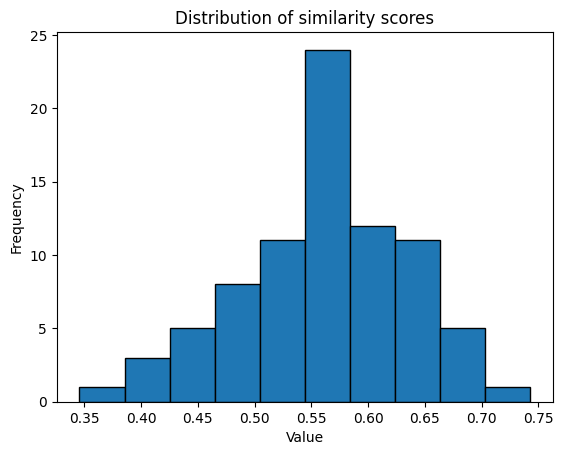

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

scores =  [score for (url, score) in all_scores_sb[1:-1]]
data = np.array(scores)

# Plotting the histogram
plt.hist(data, bins=10, edgecolor='black')  # bins control the number of bars
plt.title("Distribution of similarity scores")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [ ]:
all_scores = calculate_similarity_score(bm_embedding, article_eb_array)

https://chenshuz.substack.com/p/burning-man-stories-how-to-figure : 0.9999993712456207
https://chenshuz.substack.com/p/13-no-i-didnt-travel-on-my-sabbatical : 0.7429666655581242
https://aashisha.substack.com/p/the-mind-bin : 0.7013395282290071
https://happypixels.substack.com/p/death-fatherhood-and-ayahuasca : 0.6760240920269984
https://open.substack.com/pub/carlosdexplorer/p/surf-and-the-art-of-solopreneurship : 0.6706976732270227
https://wanderingwithwaning.substack.com/p/gn-49-figuring-out-whats-the-plan : 0.6685755548188304
https://changesurfer.substack.com/p/how-to-walk-to-a-mens-group : 0.6677199992229487
https://coco.substack.com/p/slow-spaces-for-conversation : 0.6615433049978099
https://open.substack.com/pub/javierpgomez/p/third-times-the-missing-element-in : 0.659526984762544
https://www.honestlyhuman.com/p/the-antidote-to-writers-block-is : 0.6589651689027929
https://open.substack.com/pub/aliviaduran/p/independence-is-overrated : 0.658118097777028
https://kaichun.substack.co

In [ ]:
len(all_scores)

83

In [ ]:
article_eb_array[0]

array([ 0.0370124 ,  0.03689481,  0.00766559, ..., -0.01286908,
        0.0101424 , -0.01586036])

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Sample data: dictionary of 80 embeddings with associated keys
data = {
    f"{urls[i]}": article_eb_array[i] for i in range(83)  # Replace with your actual embeddings
}

# Extract keys and embeddings
keys = list(data.keys())
embeddings = np.array(list(data.values()))

# Perform KMeans clustering
n_clusters = 5  # Choose the number of clusters as appropriate
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)

# Map each key to its cluster label
clustered_data = {key: label for key, label in zip(keys, labels)}

# Print or analyze the clustering result
print(clustered_data)


{'https://open.substack.com/pub/attuned/p/the-good-ancestor': 1, 'https://thecopywise.com/articles/f/the-things-we-give-up-when-we%E2%80%99re-rushing-through-life': 4, 'https://joeballou.substack.com/p/the-worship-of-wealth-part-1-the': 0, 'https://open.substack.com/pub/carlosdexplorer/p/surf-and-the-art-of-solopreneurship': 3, 'https://changesurfer.substack.com/p/how-to-walk-to-a-mens-group': 2, 'https://open.substack.com/pub/bluemamba/p/you-can-talk-to-each-other': 2, 'https://coco.substack.com/p/slow-spaces-for-conversation': 3, 'https://landino.substack.com/p/the-decline-of-wonder': 1, 'https://open.substack.com/pub/treadstonecapital/p/if-you-want-it': 0, 'https://open.substack.com/pub/conscrumptious/p/a-life-lost-in-wonder': 1, 'https://petebutters.substack.com/p/pepper-sprayed-in-paris': 2, 'https://www.deeptichopra.com/p/failing-publicly': 2, 'https://open.substack.com/pub/thecuriosityventure/p/product-managers-should-remember': 0, 'https://open.substack.com/pub/orgchart/p/the-l

In [ ]:
groups= {}
for key, label in clustered_data.items():
  if label not in groups:
    groups[label] = []
  groups[label].append(key)